In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow.keras.backend as K

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, LogCoshError

In [65]:
# Functions

def increase_dummies(x):
    if x > 0:
        return 1
    else:
        return 0
    
def descending_sort_features(features, importances):
    indices = np.argsort(importances)
    
    sorted_importances = importances[indices[::-1]]
    sorted_features = features[indices[::-1]]
    
    result = np.dstack((sorted_features, sorted_importances))[0].tolist()
    
    return result

def window_feature_data(df, window, feature_cols_i):
    
    X = []

    for i in range(len(df) - window):
        X.append(df.iloc[i : (i + window), feature_cols_i].values.tolist())

    return np.array(X)
                      
def window_target_data(df, window, target_col_i):
    
    y = []
    
    for i in range(len(df) - window):
        y.append(df.iloc[(i + window), target_col_i])
            
    return np.array(y).reshape(-1, 1)

def sentiment_dataframe_setup(watson_dataframe, indices_dataframe):
    
    # Pivot on Ticker
    indices_pivot = indices_dataframe.pivot(columns = "Ticker", values  = "Close")
    
    # Forward fill on any na in indices
    indices_pivot = indices_pivot.fillna(method="ffill")
    
    # Rename columns so its clear that these are closes

    d = {
        'CAC' : 'CAC Close',
        'FTSE' : 'FTSE Close',
        'MDAX' : 'MDAX Close',
        'SP500' : 'SP500 Close',
        'TOPIX' : 'TOPIX Close'
    }

    indices_pivot = indices_pivot.rename(columns=d)
    
    # Calculate percent change for each index

    indices_pivot.insert(0, "TOPIX percent change", indices_pivot['TOPIX Close'].pct_change() * 100)
    indices_pivot.insert(0, "SP500 percent change", indices_pivot['SP500 Close'].pct_change() * 100)
    indices_pivot.insert(0, "MDAX percent change", indices_pivot['MDAX Close'].pct_change() * 100)
    indices_pivot.insert(0, "FTSE percent change", indices_pivot['FTSE Close'].pct_change() * 100)
    indices_pivot.insert(0, "CAC percent change", indices_pivot['CAC Close'].pct_change() * 100)
    
    # create copy of read-in watson features and drop unneccesary information
    sentiment_df = watson_df.drop(columns=['Source', 'Headline', 'Lead Paragraph', 'URL'])
    
    # get dummies
    sentiment_df = pd.get_dummies(sentiment_df)
    
    # group by date and take the mean of the sentiment scores
    mean_sentiment_df = sentiment_df.groupby(['Date']).mean()
    
    # concatenate the features and target data
    mean_sentiment_df = pd.concat([indices_pivot, mean_sentiment_df], axis=1)
    
    # create categories for the percent increase, 1 for increase, 0 for decrease/no change
    mean_sentiment_df.insert(0, "TOPIX increase", mean_sentiment_df['TOPIX percent change'].apply(increase_dummies))
    mean_sentiment_df.insert(0, "SP500 increase", mean_sentiment_df['SP500 percent change'].apply(increase_dummies))
    mean_sentiment_df.insert(0, "MDAX increase", mean_sentiment_df['MDAX percent change'].apply(increase_dummies))
    mean_sentiment_df.insert(0, "FTSE increase", mean_sentiment_df['FTSE percent change'].apply(increase_dummies))
    mean_sentiment_df.insert(0, "CAC increase", mean_sentiment_df['CAC percent change'].apply(increase_dummies))

    # create categories for the sentiment, 1 for positive, 0 for negative/neutral
    mean_sentiment_df['Headline Sentiment'] = mean_sentiment_df["Headline Sentiment"].apply(increase_dummies)
    mean_sentiment_df['Lead Paragraph Sentiment'] = mean_sentiment_df["Lead Paragraph Sentiment"].apply(increase_dummies)
    
    # Drop na
    mean_sentiment_df.dropna(inplace=True)
    
    return mean_sentiment_df

def initialize_multi_brf_data(df, target_sections, target_columns):
    
    if len(target_sections) != len(target_columns):
        raise Exception('target_sections and target_columns must be the same length')
        
    data = {}
    features = {}
    
    for i, key in enumerate(target_sections):
        data[key] = {
            "target": df[target_columns[i]]
        }
    
    x_cols = [i for i in brf_df.columns if i not in target_columns]
    features["X"] = df[x_cols]
        
    return data, features

def run_multi_brf(brf_results, brf_features, number_trees=1000, train_size=0.7, split_rng=1, brf_rng=1, print_progress=False):
    
    scaler = StandardScaler()
    model = BalancedRandomForestClassifier(n_estimators=number_trees, random_state=brf_rng)
    
    # split and scale features
    brf_features["X train"], brf_features["X test"] = train_test_split(brf_features["X"], train_size=train_size, random_state=split_rng)   
    scaler.fit(brf_features["X train"])
    brf_features["X train scaled"] = scaler.transform(brf_features["X train"])
    brf_features["X test scaled"] = scaler.transform(brf_features["X test"])
    
    # since this is a dictionary of dictionary, the value itself can have key-value pairs
    # section_data["target"] should have been initalized in the initialize_multi_ml_data function
    for key, section_data in brf_results.items():
    
        if(print_progress):
            print(f"{key} start")
    
        section_data["y train"], section_data["y test"] = train_test_split(section_data["target"], train_size=train_size, random_state=split_rng)
        
        model.fit(brf_features["X train scaled"], section_data["y train"])
    
        section_data["predictions"] = model.predict(brf_features["X test scaled"])
    
        section_data["Accuracy"] = balanced_accuracy_score(section_data["y test"], section_data["predictions"]) 
    
        section_data["Confusion Matrix"] = confusion_matrix(section_data["y test"], section_data["predictions"])
    
        section_data["Classification Report"] = classification_report_imbalanced(
            section_data["y test"], 
            section_data["predictions"], 
            digits=4
        )
    
        section_data["Feature Importance"] = descending_sort_features(
            brf_features["X train"].columns, 
            model.feature_importances_
        )
        
        if(print_progress):
            print(f"{key} end")
        
    del model
    
    return scaler

def print_brf_results(brf_results):
    
    for key, value in brf_results.items():
        print(f"{key} Accuracy: {value['Accuracy']:.4f}\n")
        print(f"{key} Confusion Matrix: \n{value['Confusion Matrix']}\n")
        print(f"{key} Classification Report: \n{value['Classification Report']}\n")
        print(f"{key} Top Five features")
    
        for i in range(5):
            print(f"{value['Feature Importance'][i][0]}: {value['Feature Importance'][i][1]:.4f}")
        
        print("\n")
        
def lstm_window_feature_data(df, window):
    
    # An LSTM requires you to deliver batches of shape (N - window_size, window_size, num_features)
    # Should be scaled first
    
    X = []

    for i in range(len(df) - window):
        X.append(df.iloc[i : (i + window), :].values.tolist())

    return np.array(X)
                      
def lstm_window_target_data(df, window, target_col_i):
    
    y = []
    
    for i in range(len(df) - window):
        y.append(df.iloc[(i + window), target_col_i])
            
    return np.array(y).reshape(-1, 1)

def initialize_multi_lstm_data(df, target_sections, target_columns, window=5):
    
    if len(target_sections) != len(target_columns):
        raise Exception('target_sections and target_columns must be the same length')
        
    data = {}
    features = {}

    # scale features separately
    scaler = MinMaxScaler(feature_range=(-1, 1))
    features_scaled_df = df.drop(columns=target_columns)
    features_scaled_df[features_scaled_df.columns] = scaler.fit_transform(features_scaled_df[features_scaled_df.columns])
        
    features["X"] = lstm_window_feature_data(features_scaled_df, window=window)
    features["scaler"] = scaler
    
    for i, key in enumerate(target_sections):
        
        data[key] = {
            "target": lstm_window_target_data(df, window=window, target_col_i=df.columns.get_loc(target_columns[i])),
            "scaler": MinMaxScaler(feature_range=(-1, 1))
        }
        
        data[key]["scaler"].fit(data[key]["target"])
        data[key]["target"] = data[key]["scaler"].transform(data[key]["target"])
        
    return data, features

def run_multi_sequential_lstm(lstm_results, lstm_features, window, timestamps, epochs=1000, train_size=0.7, dropout_pct=0.2, print_progress=False):

    # Use default 70% of the data for training and the remainder for testing
    split = int(train_size * lstm_features["X"].shape[0])
    
    lstm_features["X train"] = lstm_features["X"][: split]
    lstm_features["X test"] = lstm_features["X"][split:]
    
    model = Sequential()
    
    return_sequences=True
    
    # create two layer LSTM model
    model.add(
        LSTM(
            units=window,
            return_sequences=True,
            input_shape=(lstm_features["X"].shape[1], lstm_features["X"].shape[2])
        )
    )
    model.add(Dropout(dropout_pct))
    model.add(LSTM(units=window))
    model.add(Dropout(dropout_pct))
    model.add(Dense(1))
    
    model.compile(
        optimizer="adam", 
        loss="mean_squared_error",
        metrics=[
            MeanAbsoluteError(), 
            LogCoshError()
        ]
    )
    
    if(print_progress):
        print(model.summary())
    
    # since this is a dictionary of dictionary, the value itself can have key-value pairs
    # section_data["target"] should have been initalized in the initialize_multi_ml_data function
    for key, section_data in lstm_results.items():
    
        if(print_progress):
            print(f"{key} start")
                        
        section_data["y train"] = section_data["target"][: split]
        section_data["y test"] = section_data["target"][split:]
    
        model.fit(lstm_features["X train"], section_data["y train"], epochs=epochs, shuffle=False, batch_size=1, verbose=1)
        
        section_data["Evaluation"] = model.evaluate(lstm_features["X test"], section_data["y test"])
    
        predicted = model.predict(lstm_features["X test"])        
        section_data["Predicted"] = section_data["scaler"].inverse_transform(predicted)
        section_data["Real"] = section_data["scaler"].inverse_transform(section_data["y test"].reshape(-1, 1))
        
        section_data["Real VS Predicted"] = pd.DataFrame({
            "Real": section_data["Real"].ravel(),
            "Predicted": section_data["Predicted"].ravel()
            }, index = timestamps[-len(section_data["Real"]): ])
        
        if(print_progress):
            print(f"{key} end")
        
    del model
    
def create_feature_importance_frames(brf_results):
    indices = []
    accuracies = []
    top_features_list = []

    for key, data in brf_results.items():
        indices.append(key)
        accuracies.append(data["Accuracy"])
        
        top_5_features = []
        
        for x in range(0,5):
            feat = data['Feature Importance'][x][0]
            top_5_features.append(feat)
        top_features_list.append(top_5_features)
        
    feat_dict = {indices[i]: top_features_list[i] for i in range(len(indices))}
    df_feat = pd.DataFrame(data = feat_dict)
        
    df_accuracy = pd.DataFrame(data = {'Index': indices, 'Accuracy Score': accuracies})
    df_accuracy.set_index('Index', inplace = True)
    df_accuracy = df_accuracy.sort_values(by = 'Accuracy Score',ascending = False)
    
    return df_feat, df_accuracy

def print_lstm_evaulations(lstm_results, target_type):
    
    for key, data in lstm_results.items():
        print(f"{key} LSTM errors for {target_type}")        
        print(f"{key} Mean Squared Error: {data['Evaluation'][0]:.4f}")
        print(f"{key} Mean Absolute Error: {data['Evaluation'][1]:.4f}")
        print(f"{key} Hyperbolic Cosine Error: {data['Evaluation'][2]:.4f}\n\n")

In [3]:
# read in saved csv
watson_path = Path('data/raw_nyt_watson.csv')
indices_path = Path('data/global_indicies.csv')

# read in watson and indices dataframes
watson_df = pd.read_csv(watson_path, parse_dates=True, index_col='Date')

indices_df = pd.read_csv(indices_path)
indices_df["Date"] = pd.to_datetime(indices_df["Date"]).dt.date
indices_df = indices_df.set_index("Date")

# define target lists for two different models
pct_columns = ["CAC percent change", "FTSE percent change", "MDAX percent change", "SP500 percent change", "TOPIX percent change"]
inc_columns = ["CAC increase", "FTSE increase", "MDAX increase", "SP500 increase", "TOPIX increase"]
cls_columns = ['CAC Close', 'FTSE Close', 'MDAX Close', 'SP500 Close', 'TOPIX Close']

indices = ["CAC", "FTSE", "MDAX", "SP500", "TOPIX"]

# create combined dataframe
combined_df = sentiment_dataframe_setup(watson_dataframe=watson_df, indices_dataframe=indices_df)

# create dataframe for BalancedRandomForest
brf_df = combined_df.drop(cls_columns+pct_columns, axis=1)

# create dictionaries for BalancedRandomForest
brf_indices, brf_features = initialize_multi_brf_data(df=brf_df, target_sections=indices, target_columns=inc_columns)

# run multiple BRF models and return scaler
brf_scaler = run_multi_brf(brf_indices, brf_features, number_trees=10000, print_progress=True)

CAC start
CAC end
FTSE start
FTSE end
MDAX start
MDAX end
SP500 start
SP500 end
TOPIX start
TOPIX end


In [4]:
lstm_pct_df = combined_df.drop(inc_columns+cls_columns, axis=1)
lstm_cls_df = combined_df.drop(inc_columns+pct_columns, axis=1)

In [5]:
lstm_pct_indices, lstm_pct_features = initialize_multi_lstm_data(df=lstm_pct_df, target_sections=indices, target_columns=pct_columns, window=5)
lstm_cls_indices, lstm_cls_features = initialize_multi_lstm_data(df=lstm_cls_df, target_sections=indices, target_columns=cls_columns, window=5)

In [6]:
run_multi_sequential_lstm(
    lstm_results=lstm_pct_indices, 
    lstm_features=lstm_pct_features, 
    window=5, 
    timestamps=lstm_pct_df.index, 
    epochs=1000,
    print_progress=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 5)              420       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 646
Trainable params: 646
Non-trainable params: 0
_________________________________________________________________
None
CAC start
Epoch 1/1000
193/193 [==============================] - 2s 1ms/step - loss: 0.0633 - mean_absolute_error: 0.2

In [7]:
run_multi_sequential_lstm(
    lstm_results=lstm_cls_indices, 
    lstm_features=lstm_cls_features, 
    window=5, 
    timestamps=lstm_cls_df.index,
    epochs=1000,
    print_progress=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 5)              420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 646
Trainable params: 646
Non-trainable params: 0
_________________________________________________________________
None
CAC start
Epoch 1/1000
193/193 [==============================] - 2s 1ms/step - loss: 0.5773 - mean_absolute_error: 0


Bad key "text.kerning_factor" on line 4 in
C:\Users\mathl\anaconda3\envs\project2env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


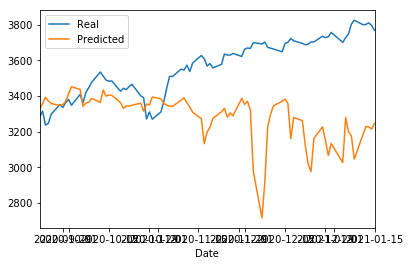

In [8]:
lstm_cls_indices["SP500"]["Real VS Predicted"].plot()

In [10]:
print_brf_results(brf_indices)

CAC Accuracy: 0.5343

CAC Confusion Matrix: 
[[22 13]
 [28 22]]

CAC Classification Report: 
                   pre       rec       spe        f1       geo       iba       sup

          0     0.4400    0.6286    0.4400    0.5176    0.5259    0.2818        35
          1     0.6286    0.4400    0.6286    0.5176    0.5259    0.2714        50

avg / total     0.5509    0.5176    0.5509    0.5176    0.5259    0.2757        85


CAC Top Five features
Headline Anger: 0.0853
Lead Paragraph Sadness: 0.0829
Headline Joy: 0.0814
Lead Paragraph Anger: 0.0793
Lead Paragraph Fear: 0.0769


FTSE Accuracy: 0.4338

FTSE Confusion Matrix: 
[[19 18]
 [31 17]]

FTSE Classification Report: 
                   pre       rec       spe        f1       geo       iba       sup

          0     0.3800    0.5135    0.3542    0.4368    0.4265    0.1848        37
          1     0.4857    0.3542    0.5135    0.4096    0.4265    0.1790        48

avg / total     0.4397    0.4235    0.4442    0.4215    0.4265    0.

In [20]:
brf_indices['CAC']['Feature Importance'][0:5]

[['Headline Anger', 0.08532187901186973],
 ['Lead Paragraph Sadness', 0.08294237896322865],
 ['Headline Joy', 0.08135345873099854],
 ['Lead Paragraph Anger', 0.07928008228533252],
 ['Lead Paragraph Fear', 0.07688916315255231]]

In [35]:
df_feat, df_accuracy = create_feature_importance_frames(brf_indices)


In [36]:
df_feat

,CAC,FTSE,MDAX,SP500,TOPIX
0,Headline Anger,Headline Disgust,Section_Business,Lead Paragraph Sadness,Section_Foreign
1,Lead Paragraph Sadness,Lead Paragraph Sadness,Headline Disgust,Headline Disgust,Headline Joy
2,Headline Joy,Lead Paragraph Joy,Headline Anger,Lead Paragraph Disgust,Lead Paragraph Fear
3,Lead Paragraph Anger,Headline Fear,Headline Joy,Headline Sadness,Lead Paragraph Sadness
4,Lead Paragraph Fear,Section_Business,Lead Paragraph Anger,Lead Paragraph Anger,Headline Anger


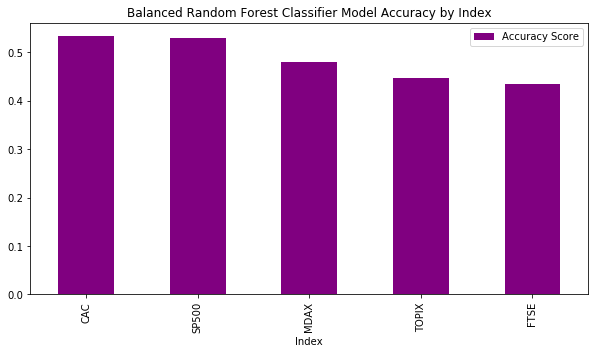

In [37]:
df_accuracy.plot(kind = 'bar', title = 'Balanced Random Forest Classifier Model Accuracy by Index' , color = 'purple', figsize = (10,5))

In [66]:
print_lstm_evaulations(lstm_cls_indices, "Close")

CAC LSTM errors for Close
CAC Mean Squared Error: 0.1174
CAC Mean Absolute Error: 0.2662
CAC Hyperbolic Cosine Error: 0.0554


FTSE LSTM errors for Close
FTSE Mean Squared Error: 0.1056
FTSE Mean Absolute Error: 0.2415
FTSE Hyperbolic Cosine Error: 0.0498


MDAX LSTM errors for Close
MDAX Mean Squared Error: 0.1421
MDAX Mean Absolute Error: 0.2700
MDAX Hyperbolic Cosine Error: 0.0662


SP500 LSTM errors for Close
SP500 Mean Squared Error: 0.2304
SP500 Mean Absolute Error: 0.3775
SP500 Hyperbolic Cosine Error: 0.1056


TOPIX LSTM errors for Close
TOPIX Mean Squared Error: 0.1294
TOPIX Mean Absolute Error: 0.2608
TOPIX Hyperbolic Cosine Error: 0.0603




In [67]:
print_lstm_evaulations(lstm_pct_indices, "Percent Change")

CAC LSTM errors for Percent Change
CAC Mean Squared Error: 0.0408
CAC Mean Absolute Error: 0.1404
CAC Hyperbolic Cosine Error: 0.0197


FTSE LSTM errors for Percent Change
FTSE Mean Squared Error: 0.0553
FTSE Mean Absolute Error: 0.1677
FTSE Hyperbolic Cosine Error: 0.0265


MDAX LSTM errors for Percent Change
MDAX Mean Squared Error: 0.0320
MDAX Mean Absolute Error: 0.1315
MDAX Hyperbolic Cosine Error: 0.0156


SP500 LSTM errors for Percent Change
SP500 Mean Squared Error: 0.0304
SP500 Mean Absolute Error: 0.1299
SP500 Hyperbolic Cosine Error: 0.0149


TOPIX LSTM errors for Percent Change
TOPIX Mean Squared Error: 0.0410
TOPIX Mean Absolute Error: 0.1495
TOPIX Hyperbolic Cosine Error: 0.0199




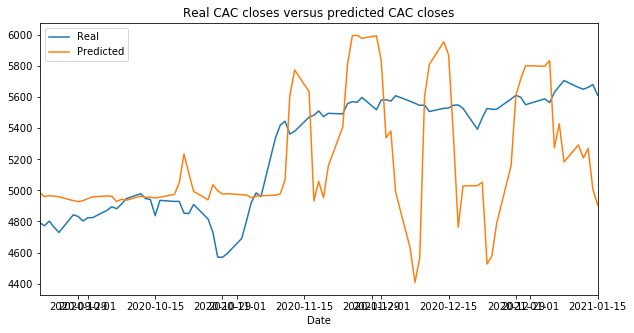

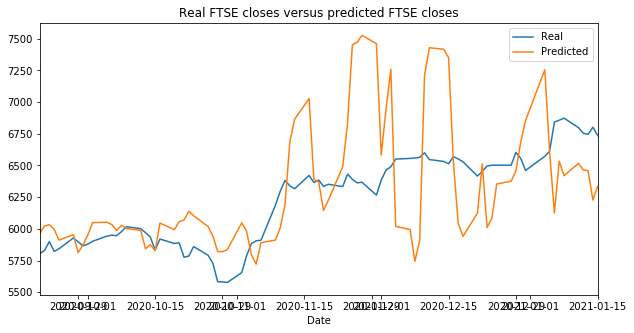

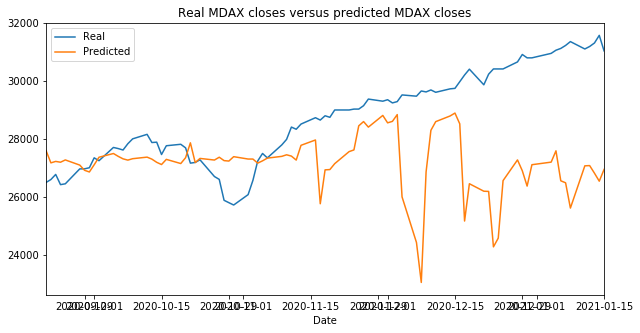

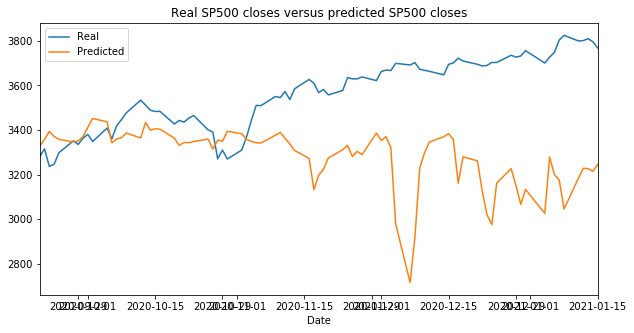

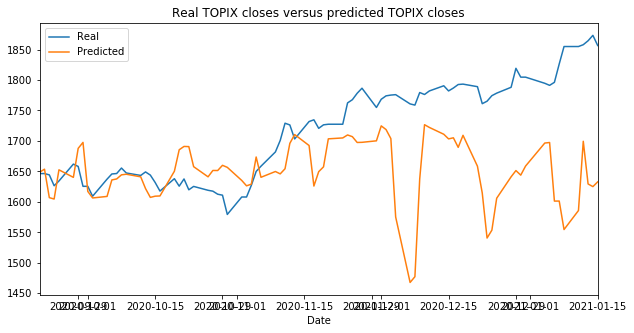

In [68]:
for key, data in lstm_cls_indices.items():
    data["Real VS Predicted"].plot(title = f"Real {key} closes versus predicted {key} closes", figsize = (10,5))

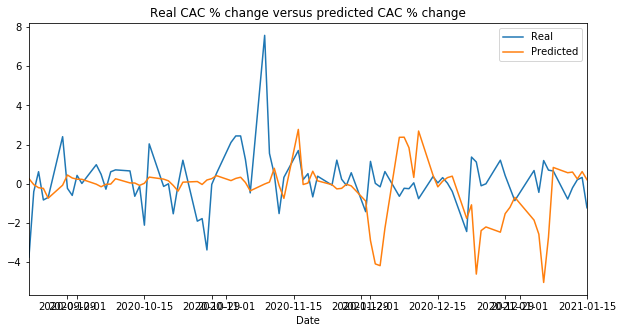

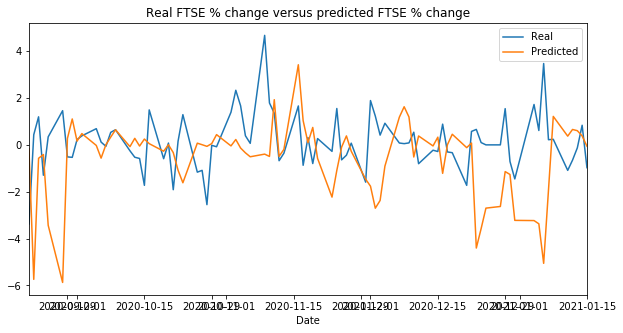

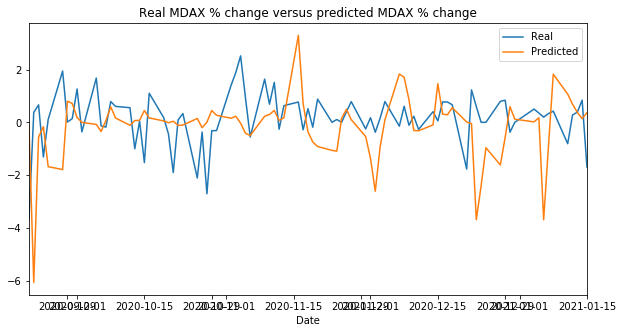

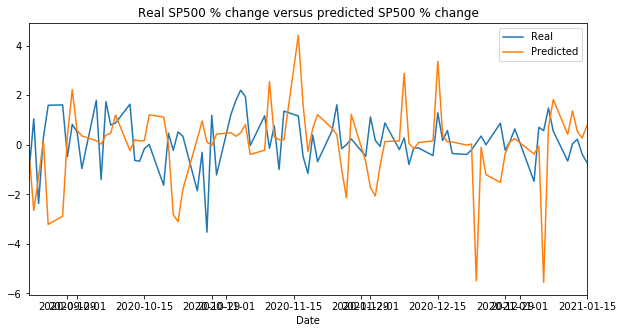

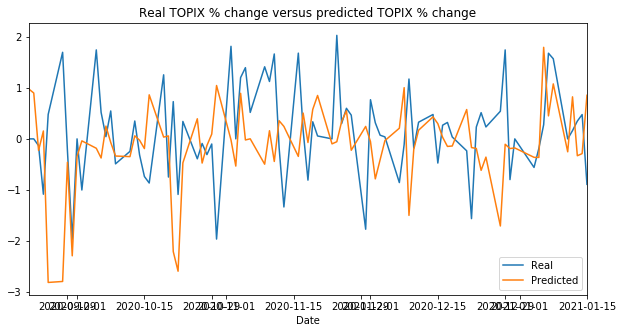

In [69]:
for key, data in lstm_pct_indices.items():
    data["Real VS Predicted"].plot(title = f"Real {key} % change versus predicted {key} % change", figsize = (10,5))